In [2]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
from d2l import torch as d2l
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [3]:
vgg = models.vgg19(pretrained = True).features
for param in vgg.parameters():
    param.requires_grad_(False)

E:\Anacoda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anacoda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
device = d2l.try_gpu()
vgg.to(device)
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
def load_img(file_path, max_size=400, shape=None):
    img = Image.open(file_path).convert('RGB')
    if max(img.size) > max_size:
        size = max_size
    else:
        size = max(img.size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])
    return in_transform(img)[:3, :, :].unsqueeze(0)


In [6]:
content_path = 'E:\毕设\style_transfer\content_img\\4.png'
style_path = 'E:\毕设\style_transfer\style_img\\1.png'
content = load_img(content_path).to(device)
# Resize style to match content, makes code easier
style = load_img(style_path, shape=content.shape[-2:]).to(device)

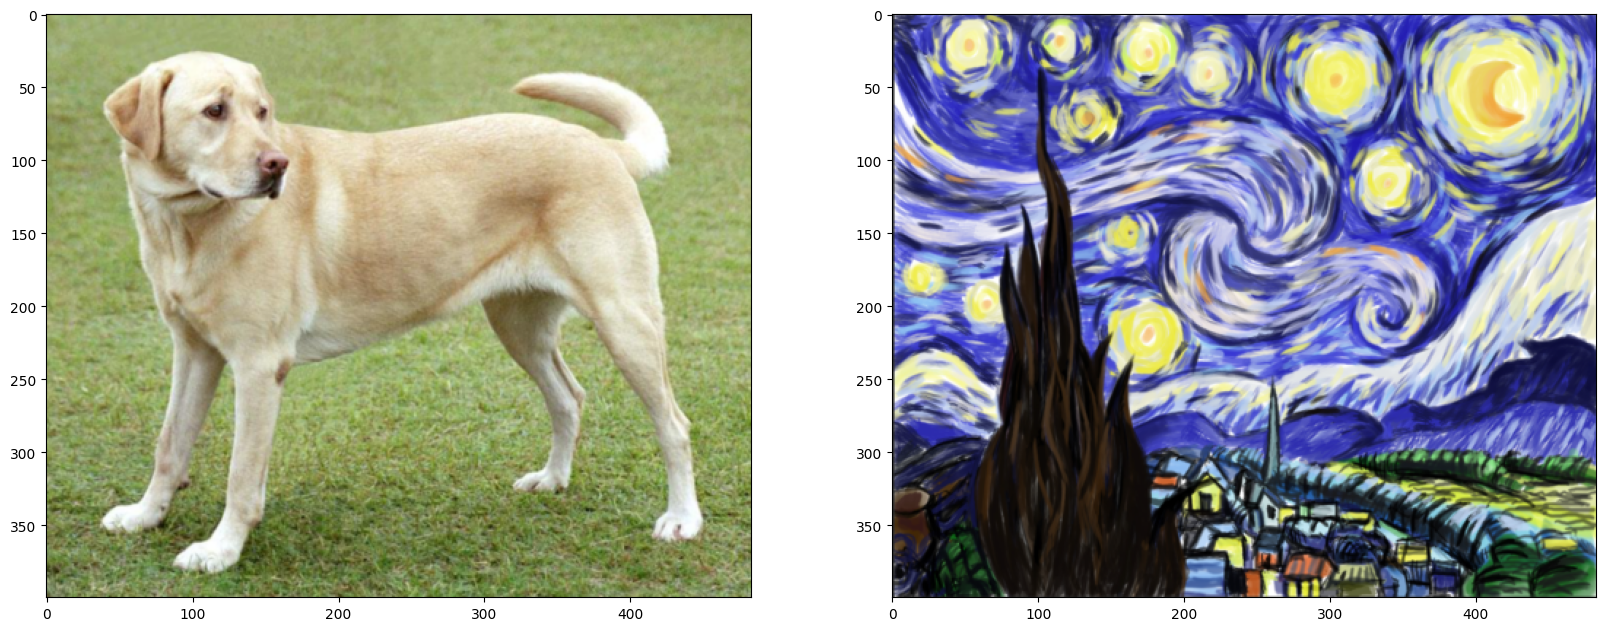

In [7]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))


In [8]:
def get_features(image, net, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    features = {}
    x = image
    # 看下model内部是什么
    for name, layer in net._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [9]:
def gram_matrix(tensor):
    _, depth, height, width = tensor.size()
    # view函数作用是什么
    tensor = tensor.view(depth, height * width)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [10]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# 风格层计算GRAM矩阵
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# 目标图像初始化
target = content.clone().requires_grad_(True).to(device)


In [11]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta


Total loss:  1905892.75


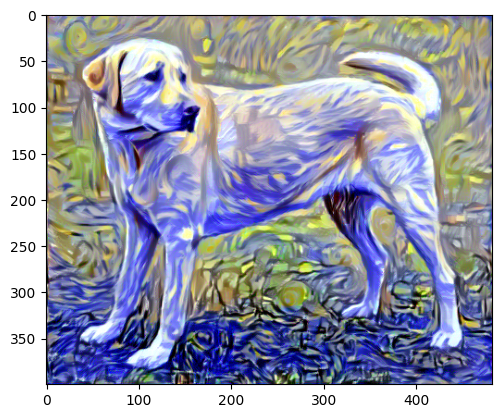

Total loss:  968334.6875


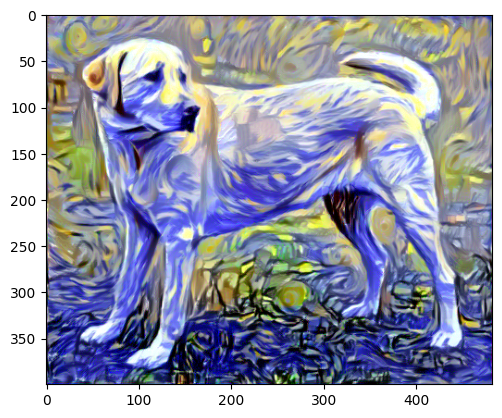

Total loss:  616288.8125


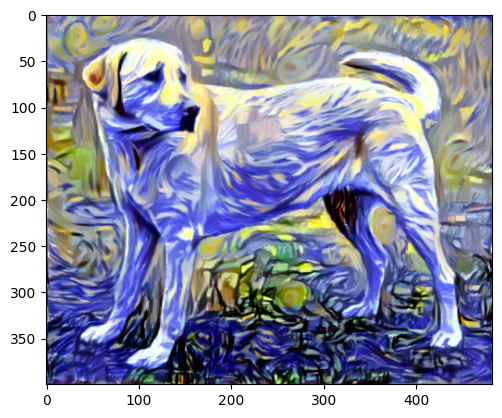

Total loss:  450435.3125


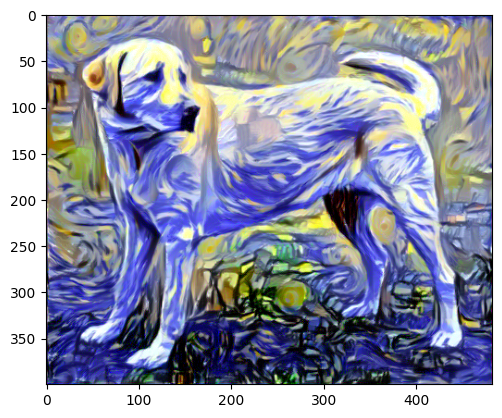

Total loss:  361164.96875


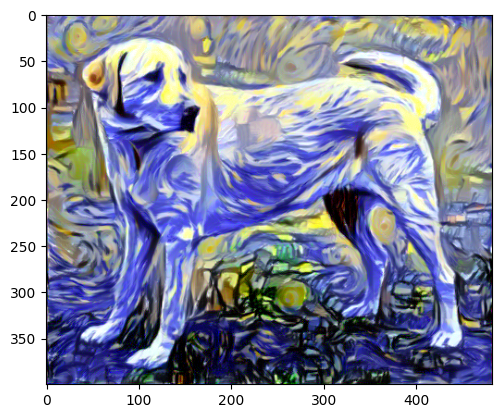

Total loss:  305905.4375


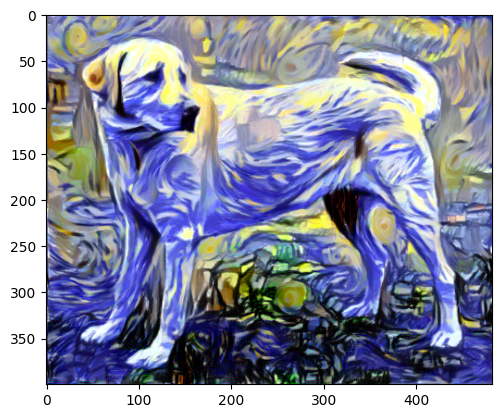

Total loss:  268220.21875


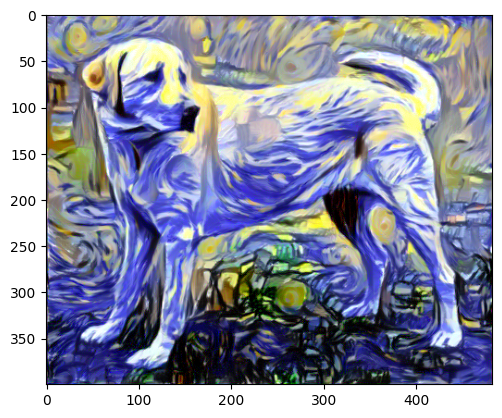

In [14]:
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2500  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    # 获取目标图像特征
    target_features = get_features(target, vgg)
    # 计算内容损失
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    # 计算风格损失
    style_loss = 0
    # 计算风格层每层GRAM矩阵与目标层GRAM矩阵的损失
    for layer in style_weights:
        # 获取目标图像的风格层并将其转为GRAM矩阵
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, depth, height, width = target_feature.shape
        # 获取当前层的风格层GRAM矩阵
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (depth * height * width)
    total_loss = content_weight * content_loss + style_weight * style_loss
    # 训练
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()


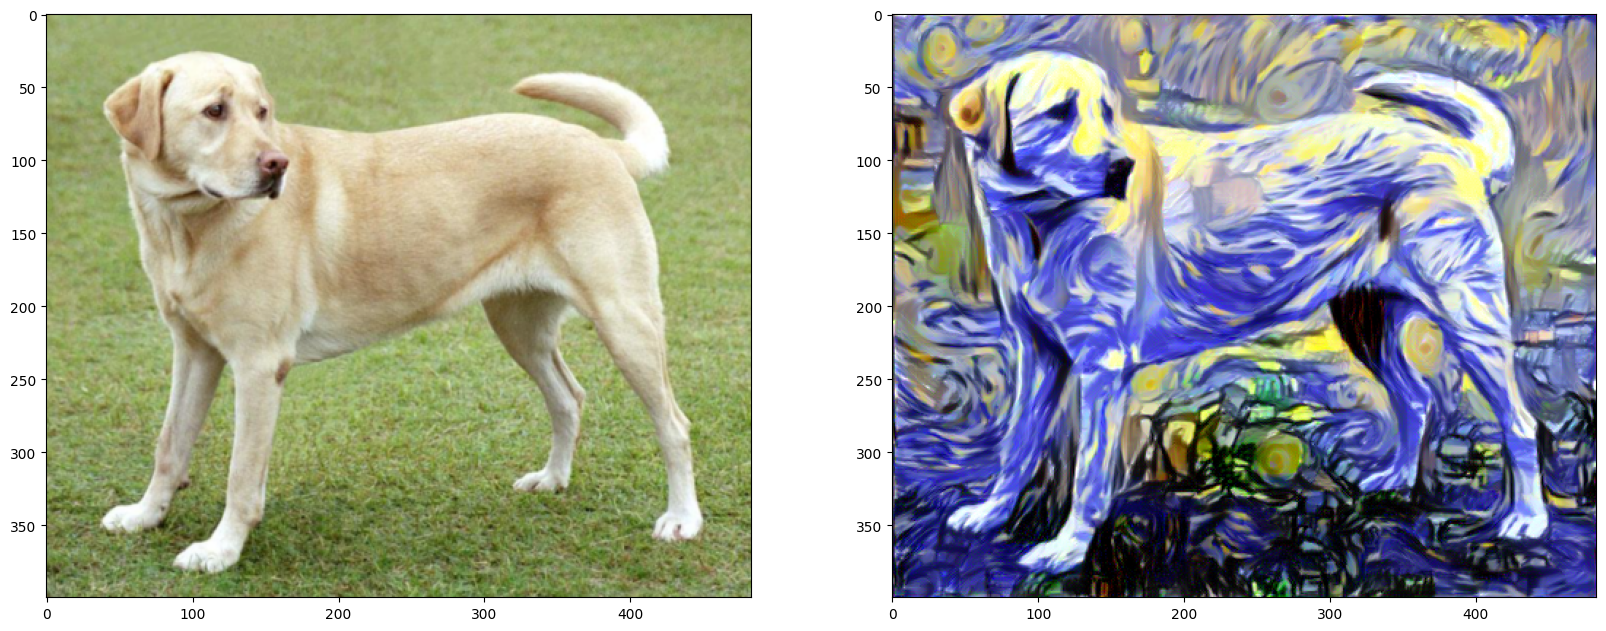

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))